In [ ]:
# E_06 Text_embedding_kor  

----  
#####목차  
1. tokenize  
2. RNN  
3. CNN  
4. MIX  
5. word2vec  

----  
난이도가 상당하여 우수코드를 참고하였습니다.

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant
from gensim.models import KeyedVectors
from konlpy.tag import Mecab

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=13000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복값 제거
    train_data = train_data.dropna(how = 'any')  # NA값 제거
    
    test_data.drop_duplicates(subset=['document'], inplace=True) # 중복값 제거
    test_data = test_data.dropna(how = 'any')  # NA값 제거 
    
    x_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        x_train.append(temp_X)

    x_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        x_test.append(temp_X)
    
    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(int(num_words)-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} # 딕셔너리에 {텍스트:인덱스} 구조로 저장
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<PAD>'] for word in wordlist]
        
    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))
        
    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

In [3]:
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
print(len(index_to_word))
print(index_to_word[11111])
print(x_train[0])

13000
펠레
[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]


In [6]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [7]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
x_train = pad_sequences(x_train,
                         value=word_to_index["<PAD>"],
                         padding='pre',
                         maxlen=maxlen)

x_test = pad_sequences(x_test,
                        value=word_to_index["<PAD>"],
                        padding='pre',
                        maxlen=maxlen)

print(x_train.shape)

(146182, 41)


In [9]:
vocab_size = 13000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 50  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(100))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          650000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               60400     
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9

In [10]:
from sklearn.model_selection import train_test_split
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, 
                                                 random_state=1, shuffle=False)

In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
286/286 [==============================] - 6s 10ms/step - loss: 0.4331 - accuracy: 0.7983 - val_loss: 0.3584 - val_accuracy: 0.8449
Epoch 2/5
286/286 [==============================] - 2s 9ms/step - loss: 0.3195 - accuracy: 0.8640 - val_loss: 0.3465 - val_accuracy: 0.8485
Epoch 3/5
286/286 [==============================] - 2s 9ms/step - loss: 0.2887 - accuracy: 0.8775 - val_loss: 0.3412 - val_accuracy: 0.8513
Epoch 4/5
286/286 [==============================] - 3s 9ms/step - loss: 0.2591 - accuracy: 0.8923 - val_loss: 0.3585 - val_accuracy: 0.8526
Epoch 5/5
286/286 [==============================] - 2s 9ms/step - loss: 0.2347 - accuracy: 0.9039 - val_loss: 0.3658 - val_accuracy: 0.8507


In [12]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

769/769 - 2s - loss: 0.3555 - accuracy: 0.8510
[0.3555220663547516, 0.8510456681251526]


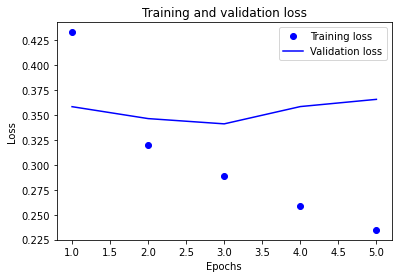

In [13]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [14]:
vocab_size = 13000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 50   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          650000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          5616      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
286/286 [==============================] - 3s 6ms/step - loss: 0.4503 - accuracy: 0.7821 - val_loss: 0.3576 - val_accuracy: 0.8453
Epoch 2/5
286/286 [==============================] - 1s 5ms/step - loss: 0.3063 - accuracy: 0.8710 - val_loss: 0.3447 - val_accuracy: 0.8523
Epoch 3/5
286/286 [==============================] - 1s 5ms/step - loss: 0.2600 - accuracy: 0.8947 - val_loss: 0.3433 - val_accuracy: 0.8559
Epoch 4/5
286/286 [==============================] - 1s 5ms/step - loss: 0.2092 - accuracy: 0.9192 - val_loss: 0.3639 - val_accuracy: 0.8532
Epoch 5/5
286/286 [==============================] - 1s 5ms/step - loss: 0.1543 - accuracy: 0.9450 - val_loss: 0.4092 - val_accuracy: 0.8478


In [16]:
results = model.evaluate(x_test,  y_test, verbose=1)

print(results)

769/769 [==============================] - 2s 2ms/step - loss: 0.3960 - accuracy: 0.8497
[0.39599716663360596, 0.849743664264679]


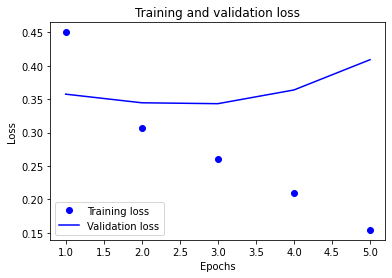

In [17]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [18]:
vocab_size = 13000
word_vector_dim = 50 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(512, 7, activation='relu'))
model.add(keras.layers.LSTM(100))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 50)          650000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 512)         179712    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               245200    
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 1,075,729
Trainable params: 1,075,729
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/3
286/286 [==============================] - 9s 24ms/step - loss: 0.3949 - accuracy: 0.8175 - val_loss: 0.3471 - val_accuracy: 0.8472
Epoch 2/3
286/286 [==============================] - 6s 23ms/step - loss: 0.2873 - accuracy: 0.8783 - val_loss: 0.3293 - val_accuracy: 0.8588
Epoch 3/3
286/286 [==============================] - 6s 23ms/step - loss: 0.2419 - accuracy: 0.9010 - val_loss: 0.3436 - val_accuracy: 0.8556


In [20]:
results = model.evaluate(x_test,  y_test, verbose=1)

print(results)

769/769 [==============================] - 2s 3ms/step - loss: 0.3322 - accuracy: 0.8582
[0.332162082195282, 0.8581658601760864]


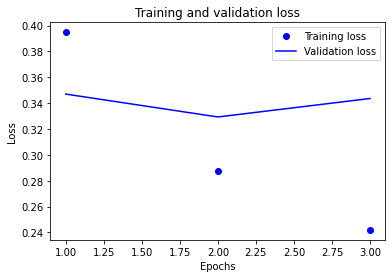

In [21]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [22]:
pip install --upgrade gensim==3.8.3

Note: you may need to restart the kernel to use updated packages.


In [35]:
from gensim.models import Word2Vec
import gensim

In [24]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'

In [25]:
word2vec = Word2Vec.load(word2vec_path)

In [26]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [27]:
print(len(train_data))

146182


In [28]:
x_train = pad_sequences(x_train,
                         value=word_to_index["<PAD>"],
                         padding='pre',
                         maxlen=maxlen)

x_test = pad_sequences(x_test,
                        value=word_to_index["<PAD>"],
                        padding='pre',
                        maxlen=maxlen)

print(x_train.shape)

(146182, 41)


In [38]:
print(word2vec.wv.vectors.shape)

(30185, 200)


In [40]:
vocab_size = 13000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_275/215132934.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_275/215132934.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [43]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
model.add(keras.layers.Conv1D(512, 7, activation='relu'))
model.add(keras.layers.LSTM(100))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2600000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 512)           717312    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               245200    
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 808       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 9         
Total params: 3,563,329
Trainable params: 3,563,329
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs= 5 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
286/286 [==============================] - 13s 38ms/step - loss: 0.5017 - accuracy: 0.7437 - val_loss: 0.3897 - val_accuracy: 0.8253
Epoch 2/5
286/286 [==============================] - 11s 37ms/step - loss: 0.3355 - accuracy: 0.8559 - val_loss: 0.3426 - val_accuracy: 0.8504
Epoch 3/5
286/286 [==============================] - 11s 37ms/step - loss: 0.2819 - accuracy: 0.8831 - val_loss: 0.3334 - val_accuracy: 0.8564
Epoch 4/5
286/286 [==============================] - 11s 37ms/step - loss: 0.2325 - accuracy: 0.9068 - val_loss: 0.3508 - val_accuracy: 0.8533
Epoch 5/5
286/286 [==============================] - 10s 37ms/step - loss: 0.1886 - accuracy: 0.9278 - val_loss: 0.3842 - val_accuracy: 0.8519


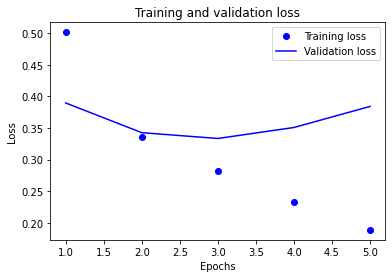

In [45]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
###회고록  

----  
우선 개발자들이 왜 Mac을 좋아하는지 알게되었다. 의외로 많은 기능들이 Window를 지원하지 않았다.  
이번 익스폴라레이션을 통해 적정 Epoch을 찾는 것이 상당히 중요하다는 것을 알게되었다.  
자연어처리는 생각보다 더 어려운 것 같다. 레이어를 깊게 만들어 보고 싶었으나, 에러가 발생하여  
포기하게 되었다. 조금 더 공부한다면 레이어를 깊게 만들 수 있을지도 모르겠다.  
아마 출력물의 모양이 다음 레이어의 입력모양과 다르다는 내용이였던 것 같다.  
의외로 Conv1D는 LSTM에 바로 넣을 수 있던데 LSTM의 출력 결과물에 대해 잘 모르는 것이  
아마 층을 깊게 만들지 못한 이유가 아닐까 싶은 생각이 들고, 층이 얕아서  
Epoch를 올리는 것이 효율을 내지 못한 것 같다는 생각이 회고를 작성하면서 들었다.

